# Make plots of input data

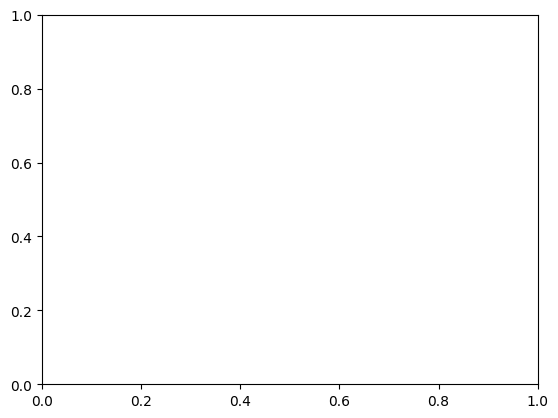

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import regionmask 

from iv_utils_daint import *

from ctsm_py.utils import *
import geopandas as gpd

set_plot_param()

## Load  updated inputdata

See https://github.com/ESCOMP/CTSM/issues/1303

Copied from there:


Technically, this should just be calculated on the fine earth fraction (1-coarse fragments).

the WISE lookup table has all of this information

| Property |	units |	long_name |
| -------- | -------- | --------- | 
| ORGC |	gC kg^-1 soil	| organic carbon content |
| BULK |	g soil cm^-3	| bulk density |
| CFRAG|	volumetric, %	| coarse fragment |

ORGANIC = ORGC * BULK * (100-CFRAG)/100  * 1/0.58 

use a prescribed value of 130 kg OM/m3 as the maximum organic matter
density, based on standard density of peat soils 

In [5]:
# directory settings

inputdir = '/project/s1207/ivanderk/scratch/processing_4p1000/'
figdir = '/users/ivanderk/notebooks_4p1000/figures/'

filename_ctsm52 = 'surfdata_360x720cru_hist_16pfts_CMIP6_2000_c230915.nc'

filename_clm5 = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
ds_input_ctsm52 = xr.open_dataset(inputdir+filename_ctsm52)


# load scenarios
scenarios = ['CTL', 'medium','high','4p1000']
inputdir_4p1000 = '/project/s1207/ivanderk/scratch/processing_4p1000/surfdata_4p1000/'
d_input_scen = {}
for scenario in scenarios: 
    filename_clm5_scenario = 'surfdata_360x720cru_16pfts_Irrig_CMIP6_simyr2000_c170824_'+scenario+'.nc'
    d_input_scen[scenario] = xr.open_dataset(inputdir_4p1000+filename_clm5_scenario)


In [18]:
# case settings
case_ctl   = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case       = case_ctl
block      = "lnd"
stream     = "h0"
variables  = ["watsat", "H2OSOI" ]
start_year = 2004
end_year   = 2004
time_slice = slice(str(start_year) + "-01-01", str(end_year) + "-12-01")
ds         = import_case(case_ctl, myVars=variables, timeSlice=time_slice,  alter_lons=False)

proj = ccrs.Robinson()
labels = ['a.','b.','c.', 'd.']


In [19]:
ds_input_ctsm52 =  ds_input_ctsm52.assign_coords(lsmlat= (ds['watsat'].lat.values)).assign_coords(lsmlon= (ds['watsat'].lon.values)).rename({'lsmlon':'lon', 'lsmlat':'lat'})

landmask = ds_input_ctsm52['LANDFRAC_PFT']>0

da_orgc    = ds_input_ctsm52['ORGC']
da_bulk    = ds_input_ctsm52['BULK']
da_cfrag   = ds_input_ctsm52['CFRAG']
da_organic = ds_input_ctsm52['ORGANIC']

da_pct_clay    = ds_input_ctsm52['PCT_CLAY']
da_pct_sand    = ds_input_ctsm52['PCT_SAND']

da_pct_crop = ds_input_ctsm52['PCT_CROP']
da_pct_grass = ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=13) + ds_input_ctsm52['PCT_NAT_PFT'].sel(natpft=14)

da_soildepth = ds_input_ctsm52['zbedrock'] #.assign_coords({"nlevsoi": (levsoi_thickness[:10])})

da_irrigated_mask = ds_input_ctsm52['PCT_CFT'].sel(cft=16)>0


ValueError: the new name 'lat' conflicts

### Plotting purpose settings

In [ ]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds['levsoi'].values
levgrnd = ds['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [ ]:
# define grid cells
df_gridcells = pd.DataFrame({   "marker": ['Laikipia, Kenya', 'Indore, India'], "lat": [0.25, 22.75 ], "lon": [37.25,75.75]})
gdf_gridcells = gpd.GeoDataFrame(df_gridcells, geometry=gpd.points_from_xy(df_gridcells.lon, df_gridcells.lat), crs="EPSG:4326")

## Plot current organic mater density at soil levels

In [ ]:

# Increase in soil organic carbon (% increase after 20 years)
soc_pctincr_20y = {}

# from Zomer et al. 2017 - CHECK UNITS
soc_pctincr_20y['medium'] = 0.27 # %
soc_pctincr_20y['high'] = 0.55 # %
soc_pctincr_20y['4p1000'] = 8 # % (0.4 %/year * 20 years)
#soc_pctincr_20y['8p1000'] = 16 # % (0.4 %/year * 20 years)

scenarios = list(soc_pctincr_20y.keys())
scenarios_and_CTL =  scenarios+['CTL']


In [ ]:
# get long names of scenarios (for plotting)

scenarios_longnames = []
d_scenarios_longnames = {}

for scenario, value in zip(scenarios, list(soc_pctincr_20y.values())): 
    
    if scenario == '4p1000': 
        scenario_name = scenario + '\n '+str(value)+' % of SOC'

    else: 
        scenario_name = scenario + '\n +'+str(value)+' %SOC'
    scenarios_longnames.append(scenario_name)
    d_scenarios_longnames[scenario] = scenario_name

In [ ]:
# Calculate new SOC data
d_orgc_20y = {}

# add soil level coordinates (to be able to subset) and convert from gC/kg to kg/kg and then to %
da_orgc_pct = da_orgc.assign_coords(nlevsoi=np.arange(0,10)) * 0.1

for scenario in scenarios: 
    print(scenario)
    print(soc_pctincr_20y[scenario])


    # select only for 5 first soil layers ( fifth soil layer goes until 0.32m depth)
    da_orgc_upper30cm = da_orgc_pct.sel(nlevsoi=slice(0,4))
    da_orgc_below30cm = da_orgc_pct.sel(nlevsoi=slice(5,len(da_orgc.nlevsoi)))


    # calculate SOC after 20 years following scenario
    if scenario == '4p1000' or scenario=='8p1000': 
        
        # accumulation rate based on current stocks
        da_orgc_20y_upper30cm_new  = da_orgc_upper30cm + da_orgc_upper30cm * soc_pctincr_20y[scenario]/100

    else: # addition of percent SOC
        
        da_orgc_20y_upper30cm_new  = (da_orgc_upper30cm + float(soc_pctincr_20y[scenario])).where(da_orgc_upper30cm>=0)


    # merge upper increased 30 cms and original below 30 cm soil levels and convert from % to gC/kg
    da_orgc_20y = xr.concat([da_orgc_20y_upper30cm_new, da_orgc_below30cm], dim='nlevsoi') * 10
    #da_orgc_20y['lsmlon'] = ds.lon.values
    #da_orgc_20y['lsmlat'] = ds.lat.values

    # save per scenario in dictionary
    d_orgc_20y[scenario] = da_orgc_20y
    
    
    

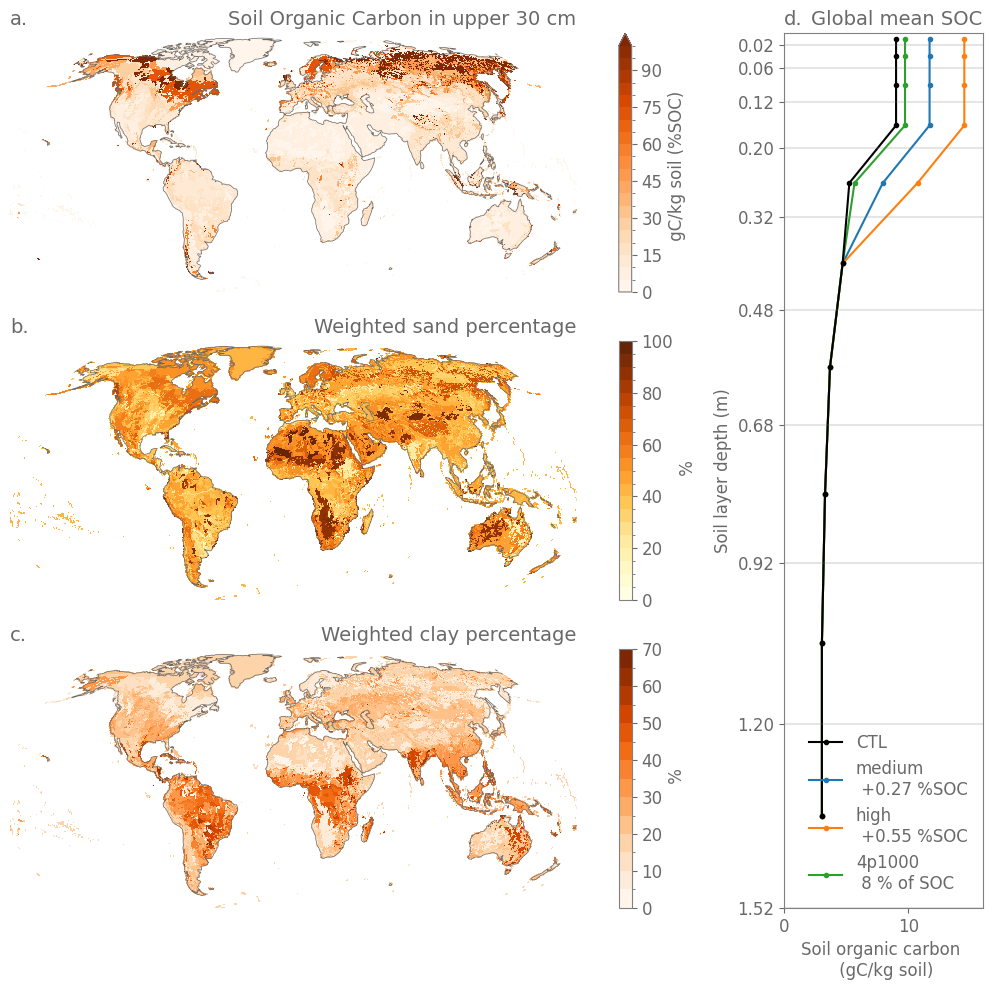

In [28]:
cmap='Oranges'


import matplotlib.gridspec as gridspec

fig = plt.figure(tight_layout=True, figsize = (16,10))
gs = gridspec.GridSpec(3, 10)


# plot SOC
# ax = axes[0]
ax = fig.add_subplot(gs[0, :-3],  projection =proj )


label = labels[0]

levels = np.arange(0,105,5)
da_toplot =  da_orgc.isel(nlevsoi=range(0,4))

da_toplot.weighted(da_toplot['nlevsoi']).mean(dim='nlevsoi').where(landmask).plot(ax=ax,transform=ccrs.PlateCarree(),  levels=levels, cmap=cmap,  cbar_kwargs={'label': ' gC/kg soil (%SOC)', 'fraction': 0.02, 'pad': 0.04})
ax.set_title(' ', loc='center')
ax.set_title('Soil Organic Carbon in upper 30 cm' , loc='right');
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_title(label, loc='left')
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')

# plot pct sand/clay

da_pct_sand_2d = da_pct_sand.weighted(da_pct_sand.nlevsoi).mean('nlevsoi')
da_pct_clay_2d = da_pct_clay.weighted(da_pct_clay.nlevsoi).mean('nlevsoi')

#ax = axes[1]
ax = fig.add_subplot(gs[1, :-3],  projection =proj)
# sand
label = labels[1]
levels = np.arange(0,105,5)
ticks =  np.arange(0,110,20)
da_pct_sand_2d.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlOrBr', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)

ax.set_title(' ', loc='center')
ax.set_title('Weighted sand percentage', loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off');


# plot pct sand/clay

ax = fig.add_subplot(gs[2, :-3],  projection =proj)
# clay
label = labels[2]
levels = np.arange(0,75,5)
ticks =  np.arange(0,75,10)

da_pct_clay_2d.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Oranges', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Weighted clay percentage', loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off');


# plot profiles
ax = fig.add_subplot(gs[:, -3:-1])
label = labels[3]


da_region = da_orgc.mean(dim=('lat','lon'))

for scenario in scenarios: 

    da_orgc_20y_toplot = d_orgc_20y[scenario]
    da_region_new =  da_orgc_20y_toplot.mean(dim=('lat','lon'))

    ax.plot(da_region_new, levsoi[:10], marker='.', alpha=1, label= d_scenarios_longnames[scenario])

ax.plot(da_region, levsoi[:10], marker='.', color='black', label='CTL')

#get handles and labels
handles, labels_legend = ax.get_legend_handles_labels()

#specify order of items in legend
order = [3,0,1,2]

#add legend to plot
plt.legend([handles[idx] for idx in order], [labels_legend[idx] for idx in order], loc='lower right', frameon=False, fontsize=12)


xlims = [-0,16]

ax.set_ylabel('Soil layer depth (m)'); 
ax.set_xlabel('Soil organic carbon \n (gC/kg soil)'); 

ax.hlines(levsoi_depth, xlims[0],xlims[1], color='grey', alpha=0.2, label='z$_{i,h}$')
#ax.hlines(levsoi_depth[7],xlims[0],xlims[1], color='darkgrey', alpha=1)
ax.vlines(0, max(levgrnd_depth),0, color='grey', alpha=0.5)

ax.set_xlim([xlims[0],xlims[1]])
ax.set_yticks(levsoi_depth)

ax.set_title('Global mean SOC', loc='right' );
ax.set_title(label, loc='left')
ax.set_ylim([max(levsoi_depth[:10]),0]); 


fig.tight_layout()

fig.savefig(figdir+'input_som.png', bbox_inches='tight')



In [ ]:

plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)
cmap='Oranges'


label = labels[0]

levels = np.arange(0,105,5)
da_toplot =  (da_organic.isel(nlevsoi=0) / 130 ) *100
da_toplot.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), levels=levels, cmap=cmap,  cbar_kwargs={'label': '% SOC', 'fraction': 0.02, 'pad': 0.04})
ax.set_title(' ', loc='center')
ax.set_title('Fraction of soil organic matter in upper 30 cm' , loc='right');
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_title(label, loc='left')
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off')



In [ ]:
fig, axes = plt.subplots(2,1,figsize=(12,7),subplot_kw={'projection': proj, 'frameon':False})

ax = axes[0]
da_increase_toplot =  da_pct_crop
label = labels[0]

# limiting values for plotting are given    
levels = np.concatenate([np.array([0,1]),(np.arange(10,110,10))])
ticks = np.concatenate([np.array([0,1]),(np.arange(10,110,20))])

da_increase_toplot.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='gist_earth_r', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
gdf_gridcells.plot(ax=ax, color='lightseagreen')

ax.set_title(' ', loc='center')
ax.set_title('Crop fraction of grid cell', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_title(label, loc='left')

# exclude Antactica from plot
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())

ax = axes[1]
label = labels[1]

da_increase_toplot =  da_pct_grass
# limiting values for plotting are given    
levels = np.concatenate([np.array([0,1]),(np.arange(10,110,10))])
ticks = np.concatenate([np.array([0,1]),(np.arange(10,110,10))])
da_increase_toplot.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='gist_earth_r', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':levels}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Grassland fraction of grid cell', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_title(label, loc='left')

# exclude Antactica from plot
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())

fig.tight_layout()

fig.savefig(figdir+'crop_grassland_fraction.png', bbox_inches='tight')



## Plot textures

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(12,7),subplot_kw={'projection':proj, 'frameon':False})
labels = ['a.','b.','c.']

da_pct_sand_2d = da_pct_sand.weighted(da_pct_sand.nlevsoi).mean('nlevsoi')
da_pct_clay_2d = da_pct_clay.weighted(da_pct_clay.nlevsoi).mean('nlevsoi')

# sand
ax = axes[0]
label = labels[0]
levels = np.arange(0,105,5)
ticks =  np.arange(0,110,20)
da_pct_sand_2d.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlOrBr', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)

ax.set_title(' ', loc='center')
ax.set_title('Weighted sand percentage', loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off');


# clay
ax = axes[1]
label = labels[1]
levels = np.arange(0,75,5)
ticks =  np.arange(0,75,10)

da_pct_clay_2d.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Oranges', cbar_kwargs={'label': ' %', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Weighted clay percentage', loc='right')
ax.set_title(label, loc='left')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off');

fig.tight_layout()
fig.savefig(figdir+'texture_maps.png', bbox_inches='tight')

## Plot soil depth

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(12,5),subplot_kw={'projection':proj, 'frameon':False})

ax = plt.subplot(111, projection=proj)

levels = np.arange(0,110,10)
da_soildepth.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='gist_earth_r', cbar_kwargs={'label': ' m', 'fraction': 0.02, 'pad': 0.04})
ax.set_title(' ', loc='center')
ax.set_title('Soil depth', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent([-180,180,-63,90], crs=ccrs.PlateCarree())
ax.axis('off');

fig.savefig(figdir+'soil_depth.png', bbox_inches='tight')